# Fake news detection on WELFake Dataset

The goal of this project is to design and implement a machine learning model capable of distinguishing between real and fake news articles by leveraging the WELFake dataset from Kaggle. The WELFake dataset comprises articles titles and text labeled as either 'fake' or 'real'. The data is updated frequently and spans a range of topics and sources, providing a diverse set of data for training a model.

## Data Cleaning & Exploration

In [244]:
# Import required libraries
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [1]:
# Load dataset from Kaggle
!kaggle datasets download -d saurabhshahane/fake-news-classification

100%|███████████████████████████████████████| 92.1M/92.1M [01:17<00:00, 740kB/s]
100%|██████████████████████████████████████| 92.1M/92.1M [01:17<00:00, 1.24MB/s]


In [2]:
# unzip 
with ZipFile('fake-news-classification.zip', 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [245]:
# read dataset
df = pd.read_csv('WELFake_Dataset.csv')

In [246]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [247]:
# drop extra index column
df = df.loc[:, ['title', 'text', 'label']]
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [248]:
df.shape

(72134, 3)

Checking for missing values.

In [249]:
df.isnull().sum()

title    558
text      39
label      0
dtype: int64

Not too many missing values, so let's delete the rows.

In [250]:
df.dropna(inplace=True)
df.shape

(71537, 3)

Let's check the distribution of 'real' and 'fake' labels. In this dataset label 1 means fake and label 0 means real.

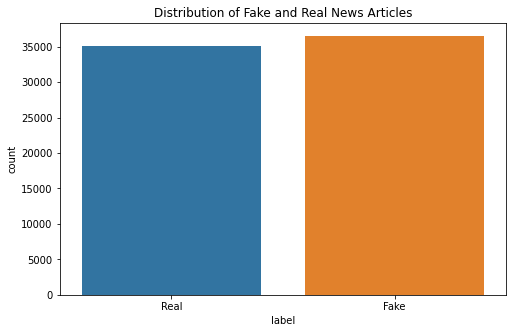

In [253]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=df, x='label')
ax.set_xticklabels(["Real", "Fake"])
plt.title('Distribution of Fake and Real News Articles')
plt.show()

The data is pretty evenly distributed.

Let's analyze article text length and title and check if there is any relation between these and its reliablity.

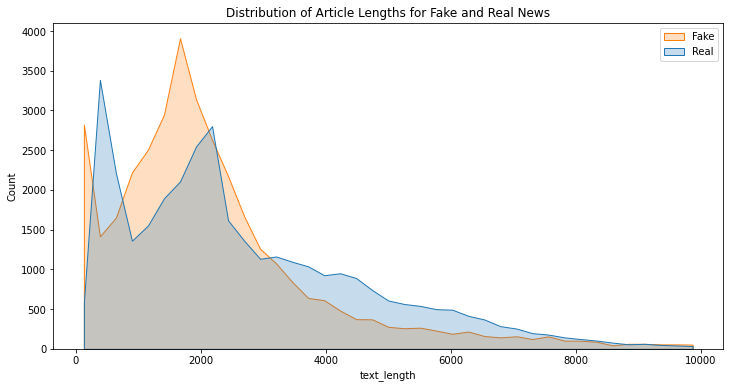

In [255]:
# Create new column for article text lengths
df['text_length'] = df['text'].apply(lambda x: len(x) - x.count(" "))

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=np.linspace(0, 10000, 40), element='poly')
plt.legend(labels=['Fake', 'Real'])
plt.title('Distribution of Article Lengths for Fake and Real News')
plt.show()

Let's do the same for article title length.

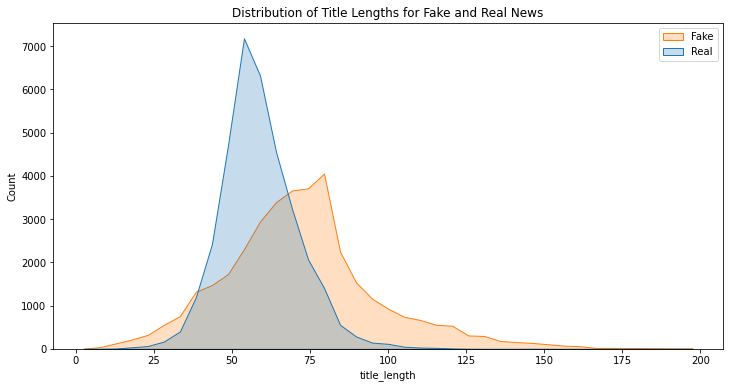

In [256]:
# Create new column for title lengths
df['title_length'] = df['title'].apply(lambda x: len(x) - x.count(" "))

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='title_length', hue='label', bins=np.linspace(0, 200, 40), element='poly')
plt.legend(labels=['Fake', 'Real'])
plt.title('Distribution of Title Lengths for Fake and Real News')
plt.show()

Fake article titles and text are concentrated in a different character range than those of real articles. So these features have some relevance to the target.

We'll use these features to train the model after scaling them.  

In [188]:
scaler = MinMaxScaler(feature_range=(0, 100))  

# Scale text and title length data to be between 0 and 10
length_cols = ['text_length', 'title_length']
df[length_cols] = pd.DataFrame(scaler.fit_transform(df[length_cols]), columns=length_cols)

Separating target and features and splitting the data into 80% train and 20% test data. 

In [189]:
df['text_full'] = df['text'] + " " + df['title']
X = df.loc[: , ['text_full', 'text_length', 'title_length']]
Y = df['label']

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

Cleaning and lemmatizing text data.

In [191]:
stop_words = set(stopwords.words('english'))
def clean_lemmatize(text):
    # remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # remove numbers
    text = re.sub('[0-9]+',' ',text)
    # remove links
    text = re.sub('https?:\S+',' ',text)
    # remove html tags
    text = re.sub('<.*?>',' ',text)
    # remove stopwords    
    words = [w.lower() for w in text.split() if w not in stop_words]
    text = " ".join(words)
    lemmatizer = WordNetLemmatizer()
    lemma_words = []
    for word in text.split():
        lemma_words.append(lemmatizer.lemmatize(word))
    return " ".join(lemma_words)

X_train['text_full'] = X_train['text_full'].apply(clean_lemmatize)
X_test['text_full'] = X_test['text_full'].apply(clean_lemmatize)
X_train.head()

,text_full,text_length,title_length
26517,conservative committing sexual assault embolde...,1.725039,13.541667
47707,figure could romantic heroine russian classic ...,5.005307,16.666667
32792,father gerald murphy go hillary clinton follow...,1.103764,12.239583
19324,in june disgraced sexual predator hollywood pr...,0.678423,17.187500
47036,edinburgh reuters a mother fighting four decad...,0.251449,18.489583


In [192]:
# Converting text to one hot representation using vocabulary size of 7000
vocab = 7000
onehot_train = [one_hot(words,vocab)for words in X_train['text_full']]
onehot_test = [one_hot(words,vocab)for words in X_test['text_full']]

In [193]:
# Padding the one hot sequences to make them of same size
train_padded = pad_sequences(onehot_train,padding='pre',maxlen=25)
test_padded = pad_sequences(onehot_test,padding='pre',maxlen=25)

In [212]:
# Converting train and test data into numpy array
X_train_final = np.append(np.array(train_padded), np.array(X_train.loc[:, ['text_length', 'title_length']]), axis=1)
y_train_final = np.array(y_train)
X_test_final = np.append(np.array(test_padded), np.array(X_test.loc[:, ['text_length', 'title_length']]), axis=1)
y_test_final = np.array(y_test)

X_train_final.shape, X_test_final.shape, y_train_final.shape, y_test_final.shape

((57229, 27), (14308, 27), (57229,), (14308,))

## Building and Training Model

Creating model with embedding and LSTM layers.

In [232]:
model = Sequential([
    Embedding(vocab, 40, input_length=27),
    Dropout(0.7),
    LSTM(64,return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.7),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [233]:
# Training model
history = model.fit(X_train_final,y_train_final,
                    validation_data=[X_test_final, y_test_final],
                    epochs=20,
                    batch_size=64)

Epoch 1/20
895/895 [==============================] - 21s 22ms/step - loss: 0.2317 - accuracy: 0.9031 - val_loss: 0.1379 - val_accuracy: 0.9469
Epoch 2/20
895/895 [==============================] - 18s 21ms/step - loss: 0.1427 - accuracy: 0.9496 - val_loss: 0.1319 - val_accuracy: 0.9499
Epoch 3/20
895/895 [==============================] - 18s 20ms/step - loss: 0.1239 - accuracy: 0.9575 - val_loss: 0.1285 - val_accuracy: 0.9527
Epoch 4/20
895/895 [==============================] - 19s 21ms/step - loss: 0.1123 - accuracy: 0.9608 - val_loss: 0.1339 - val_accuracy: 0.9504
Epoch 5/20
895/895 [==============================] - 18s 21ms/step - loss: 0.1027 - accuracy: 0.9640 - val_loss: 0.1285 - val_accuracy: 0.9524
Epoch 6/20
895/895 [==============================] - 18s 21ms/step - loss: 0.0956 - accuracy: 0.9672 - val_loss: 0.1359 - val_accuracy: 0.9539
Epoch 7/20
895/895 [==============================] - 18s 20ms/step - loss: 0.0881 - accuracy: 0.9685 - val_loss: 0.1271 - val_accuracy:

In [234]:
test_preds = (model.predict(X_test_final) > 0.5).astype("int32")
print(classification_report(y_test_final, test_preds))

448/448 [==============================] - 2s 3ms/step
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      6969
           1       0.96      0.96      0.96      7339

    accuracy                           0.96     14308
   macro avg       0.96      0.96      0.96     14308
weighted avg       0.96      0.96      0.96     14308

